In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [29]:
!pip install scikit-learn

     |████████████████████████████████| 6.8 MB 6.7 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 55.8 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [32]:
import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt
from PIL import Image
import random

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, ReLU, Dropout, MaxPooling2D
from tensorflow.nn import leaky_relu, relu
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import plot_confusion_matrix

# Data

### Dividing into train/test split

In [2]:
top_dir = './data/test'
class_folders = os.listdir(top_dir)

class_cnt = {}

for cls in class_folders:
    class_cnt[cls] = len(os.listdir(os.path.join(top_dir, cls)))

In [3]:
class_cnt

{'right': 5396,
 'left': 5398,
 'backwards': 5398,
 'forwards': 4287,
 'none': 17274}

In [4]:
num_total = np.sum([v for k, v in class_cnt.items()])
num_total

37753

In [5]:
num_valid = round(class_cnt['right'] * 0.2)
num_valid * 5

5395

In [47]:
os.mkdir('./data/train')
os.mkdir('./data/test')

In [6]:
class_folders

['right', 'left', 'backwards', 'forwards', 'none']

In [49]:
for cls in class_folders:
    os.mkdir(f'./data/test/{cls}')
    rnd = np.random.choice(os.listdir(os.path.join(top_dir, cls)), num_valid, replace=False)
    for i in range(len(rnd)):
        os.rename(os.path.join(top_dir, cls, rnd[i]), os.path.join(top_dir, 'test', cls, rnd[i]))

In [53]:
for cls in class_folders:
    os.mkdir(f'./data/train/{cls}')
    for file in os.listdir(f'./data/{cls}'):
        os.rename(os.path.join(top_dir, cls, file), os.path.join(top_dir, 'train', cls, file))

### Creating Dataset

In [7]:
batch_size = 16

In [8]:
num_train = num_total - (num_valid * 5)
num_test = num_valid * 5

In [9]:
num_train

32358

In [10]:
# data_dir_train = pathlib.Path('./data/train/')
data_dir_test = pathlib.Path('./data/test/')

In [11]:
# The training dataset is much too large to fit into memory and to shuffle with .list_files() method
# Instead, let's shuffle the filepaths manually
data_dir_train = './data/train/'

training_files = []

for cls in os.listdir(data_dir_train):
    for file in os.listdir(os.path.join(data_dir_train, cls)):
        training_files.append(os.path.join(
            data_dir_train,
            cls,
            file
        ))

In [12]:
random.shuffle(training_files)

In [11]:
# list_ds_train = tf.data.Dataset.list_files(str(data_dir_train/'*/*'), shuffle=False)
# list_ds_train = list_ds_train.shuffle(7000, reshuffle_each_iteration=True)

list_ds_test = tf.data.Dataset.list_files(str(data_dir_test/'*/*'), shuffle=False)

In [12]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)

    # The second to last is the class-directory
    one_hot = parts[-2] == class_folders

    # Integer encode the label
    return tf.argmax(one_hot)


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    
    img = tf.cast(img, tf.float32)
    img /= 255.
    
    # resize the image to the desired size
    return img

def process_path(file_path):
    label = get_label(file_path)

    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# train_ds = tf.data.Dataset.from_tensor_slices(training_files)

# train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = list_ds_test.map(process_path, num_parallel_calls=AUTOTUNE)

In [41]:
def augment_train(img, label):
    
    img = tf.image.random_brightness(img, max_delta=0.5)
    img = tf.image.random_saturation(img, lower=0.5, upper=1.5)
    
    return img, label

In [14]:
# train_ds = (
#     train_ds
# #     .shuffle(buffer_size=2500)
# #     .map(augment_train, num_parallel_calls=AUTOTUNE)
#     .batch(batch_size)
#     .prefetch(AUTOTUNE)
# )

test_ds = (
    test_ds
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

# Models

In [19]:
class ModelARIX(tf.keras.Model):
    
    def __init__(self):
        super().__init__()
        
        self.c1 = Conv2D(32, kernel_size=(7, 7), strides=2, activation=None)
        self.bn1 = BatchNormalization()
        self.m1 = MaxPooling2D(pool_size=(3, 3), strides=2)
        
        self.cb_11 = Conv2D(64, kernel_size=(3, 3), strides=1, activation=None)
        self.cb_1bn1 = BatchNormalization()
        self.cb_12 = Conv2D(64, kernel_size=(3, 3), strides=1, activation=None)
        self.cb_1bn2 = BatchNormalization()
        self.cb_1m = MaxPooling2D(pool_size=(3, 3), strides=2)
        
        self.cb_21 = Conv2D(128, kernel_size=(3, 3), strides=1, activation=None)
        self.cb_2bn1 = BatchNormalization()
        self.cb_22 = Conv2D(128, kernel_size=(3, 3), strides=1, activation=None)
        self.cb_2bn2 = BatchNormalization()
        self.cb_2m = MaxPooling2D(pool_size=(3, 3), strides=2)
        
        self.cb_31 = Conv2D(512, kernel_size=(3, 3), strides=1, activation=None)
        self.cb_3bn1 = BatchNormalization()
        self.cb_32 = Conv2D(512, kernel_size=(3, 3), strides=1, activation=None)
        self.cb_3bn2 = BatchNormalization()
        self.cb_3m = MaxPooling2D(pool_size=(3, 3), strides=2)
        
        self.drop3 = Dropout(0.2)
        self.drop4 = Dropout(0.2)
        self.gap = GlobalAveragePooling2D()
        self.d1 = Dense(256, activation='relu')
        self.out = Dense(5, activation='softmax')
        

        
    def call(self, x, training=False):
        x = self.c1(x)
        x = self.bn1(x, training=training)
        x = relu(x)
        x = self.m1(x)
        
        # 1st conv block
        x = self.cb_11(x)
        x = self.cb_1bn1(x, training=training)
        x = relu(x)
        x = self.cb_12(x)
        x = self.cb_1bn2(x, training=training)
        x = relu(x)
        x = self.cb_1m(x)
        
        # 2nd conv block
        x = self.cb_21(x)
        x = self.cb_2bn1(x, training=training)
        x = relu(x)
        x = self.cb_22(x)
        x = self.cb_2bn2(x, training=training)
        x = relu(x)
        x = self.cb_2m(x)
        
        # 3rd conv block
        x = self.cb_31(x)
        x = self.cb_3bn1(x, training=training)
        x = relu(x)
        x = self.cb_32(x)
        x = self.cb_3bn2(x, training=training)
        x = relu(x)
        x = self.drop3(x, training=training)
        x = self.cb_3m(x)
        
        x = self.gap(x)
        x = self.d1(x)
        x = self.drop4(x, training=training)
        return self.out(x)

In [31]:
model_one = ModelOne()

loss = tf.keras.losses.SparseCategoricalCrossentropy()
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6, clipnorm=1.)
optimizer_more = tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=2.)
metric = tf.keras.metrics.SparseCategoricalAccuracy()

In [32]:
@tf.function
def train(x, y):
    with tf.GradientTape() as tape:
        preds = model_one(x, training=True)
        loss_ = loss(y, preds)
    grads = tape.gradient(loss_, model_one.trainable_variables)
    optimizer_more.apply_gradients(zip(grads, model_one.trainable_variables))
    return loss_, preds

In [47]:
EPOCHS = 200

# loss_hist = []
# acc_hist = []
# acc_hist_test = []

for _ in range(EPOCHS):

    for x, y in train_ds:
        l, p = train(x, y)
        loss_hist.append(l)
        acc_hist.append(metric(y, p))

    for x, y in test_ds:
        p = model_one(x)
        acc_hist_test.append(metric(y, p))
    
            
    print(f'Epoch: {_}, Train: {np.mean(acc_hist[len(acc_hist)-780:])}, Test: {np.mean(acc_hist[len(acc_hist)-295:])}')
    
    if _ % 20 == 0:
        model_one.save(f'./results/model_one_large_{_}')
    
    random.shuffle(training_files)
    train_ds = tf.data.Dataset.from_tensor_slices(training_files)
    train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    train_ds = (
        train_ds
    #     .shuffle(buffer_size=10000)
    #     .map(augment_train, num_parallel_calls=AUTOTUNE)
        .batch(batch_size)
        .prefetch(AUTOTUNE)
    )

Epoch: 0, Train: 0.9120442867279053, Test: 0.9124776721000671
INFO:tensorflow:Assets written to: ./results/model_one_large_0/assets
Epoch: 1, Train: 0.9137678146362305, Test: 0.9141820073127747
Epoch: 2, Train: 0.9151490330696106, Test: 0.9155477285385132
Epoch: 3, Train: 0.9166211485862732, Test: 0.9170053005218506
Epoch: 4, Train: 0.9162032604217529, Test: 0.9165810942649841
Epoch: 5, Train: 0.9174689054489136, Test: 0.9178351163864136
Epoch: 6, Train: 0.918805718421936, Test: 0.9191592335700989
Epoch: 7, Train: 0.9199619293212891, Test: 0.9203029870986938
Epoch: 8, Train: 0.9208946824073792, Test: 0.9212255477905273
Epoch: 9, Train: 0.9218427538871765, Test: 0.9221600890159607
Epoch: 10, Train: 0.9232024550437927, Test: 0.9235121011734009
Epoch: 11, Train: 0.924467921257019, Test: 0.9247677326202393
Epoch: 12, Train: 0.9256564974784851, Test: 0.9259465336799622
Epoch: 13, Train: 0.9267791509628296, Test: 0.9270596504211426
Epoch: 14, Train: 0.9278860092163086, Test: 0.92815798521041

Epoch: 123, Train: 0.9674311876296997, Test: 0.9674744606018066
Epoch: 124, Train: 0.9675791263580322, Test: 0.9676219820976257
Epoch: 125, Train: 0.9677031636238098, Test: 0.9677457213401794
Epoch: 126, Train: 0.9678627848625183, Test: 0.9679043889045715
Epoch: 127, Train: 0.9680300951004028, Test: 0.9680715799331665
Epoch: 128, Train: 0.9681124091148376, Test: 0.9681535959243774
Epoch: 129, Train: 0.9682252407073975, Test: 0.9682660698890686
Epoch: 130, Train: 0.9683305621147156, Test: 0.9683710932731628
Epoch: 131, Train: 0.968418300151825, Test: 0.9684584736824036
Epoch: 132, Train: 0.9685085415840149, Test: 0.9685482978820801
Epoch: 133, Train: 0.9686168432235718, Test: 0.9686563014984131
Epoch: 134, Train: 0.9687652587890625, Test: 0.9688041806221008
Epoch: 135, Train: 0.9689168334007263, Test: 0.9689554572105408
Epoch: 136, Train: 0.9690641164779663, Test: 0.9691023230552673
Epoch: 137, Train: 0.9691680073738098, Test: 0.9692059755325317
Epoch: 138, Train: 0.9692763090133667, Te

In [48]:
model_one.save('./results/model_one_large_199/')

INFO:tensorflow:Assets written to: ./results/model_one_large_199/assets


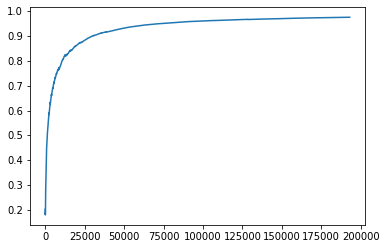

In [50]:
plt.plot(acc_hist)

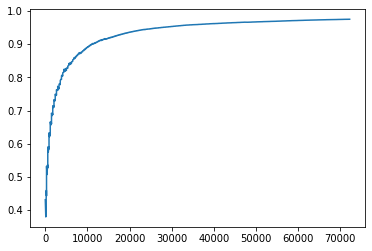

In [51]:
plt.plot(acc_hist_test)

# Evaluation

In [15]:
top_dir = './data/train'
class_folders = os.listdir(top_dir)

class_cnt = {}

for cls in class_folders:
    class_cnt[cls] = len(os.listdir(os.path.join(top_dir, cls)))
    
print(class_cnt)
print(np.sum([v for k, v in class_cnt.items()]))

{'right': 18708, 'left': 16911, 'backwards': 18707, 'forwards': 18707, 'none': 27706}
100739


In [16]:
top_dir = './data/test'
class_folders = os.listdir(top_dir)

class_cnt = {}

for cls in class_folders:
    class_cnt[cls] = len(os.listdir(os.path.join(top_dir, cls)))
    
print(class_cnt)
print(np.sum([v for k, v in class_cnt.items()]))

{'right': 5396, 'left': 5398, 'backwards': 5398, 'forwards': 4287, 'none': 17274}
37753


In [17]:
arix = tf.keras.models.load_model('./results/model_one_large_199/')

In [26]:
y_true = []
y_hat = []

for x, y in test_ds:
    preds = arix(x, training=False)
    
    for y_i in y:
        y_true.append(y_i.numpy())
        
    for preds_i in preds:
        y_hat.append(np.argmax(preds_i.numpy()))

In [27]:
np.sum(np.array(y_true) == np.array(y_hat)) / len(y_true)

0.973670966545705

In [40]:
np.set_printoptions(suppress=True)
print(class_folders)
confusion_matrix(y_true, y_hat, normalize='true')

['right', 'left', 'backwards', 'forwards', 'none']


array([[0.99351371, 0.00389177, 0.00240919, 0.        , 0.00018532],
       [0.        , 1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.00018525, 0.99981475, 0.        , 0.        ],
       [0.        , 0.00163284, 0.        , 0.995568  , 0.00279916],
       [0.00011578, 0.02043534, 0.03056617, 0.00324187, 0.94564085]])

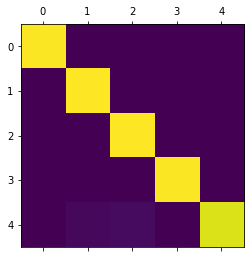

In [42]:
plt.matshow(confusion_matrix(y_true, y_hat, normalize='true'))

### Eval

In [56]:
data_dir_t = pathlib.Path('./data/t/')
list_ds_t = tf.data.Dataset.list_files(str(data_dir_t/'*'), shuffle=False)

t_ds = list_ds_t.map(process_path, num_parallel_calls=AUTOTUNE)

t_ds = (
    t_ds
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [48]:
for x, y in t_ds:
    print(x)
    print(y)
    break

tf.Tensor(
[[[[0.32156864 0.31764707 0.34117648]
   [0.3254902  0.32156864 0.34509805]
   [0.3254902  0.32156864 0.34509805]
   ...
   [0.05882353 0.05490196 0.03921569]
   [0.05882353 0.05490196 0.03921569]
   [0.05882353 0.05490196 0.03921569]]

  [[0.3372549  0.33333334 0.35686275]
   [0.3372549  0.33333334 0.35686275]
   [0.3372549  0.33333334 0.35686275]
   ...
   [0.05882353 0.05490196 0.03921569]
   [0.05882353 0.05490196 0.03921569]
   [0.05882353 0.05490196 0.03921569]]

  [[0.36078432 0.35686275 0.38039216]
   [0.36078432 0.35686275 0.38039216]
   [0.36078432 0.35686275 0.38039216]
   ...
   [0.05882353 0.05490196 0.03921569]
   [0.05882353 0.05490196 0.03921569]
   [0.05882353 0.05490196 0.03921569]]

  ...

  [[0.0627451  0.06666667 0.04313726]
   [0.06666667 0.07058824 0.04705882]
   [0.07843138 0.08235294 0.05098039]
   ...
   [0.10980392 0.11764706 0.07450981]
   [0.12156863 0.12941177 0.08627451]
   [0.1254902  0.13333334 0.09019608]]

  [[0.04705882 0.05098039 0.027450

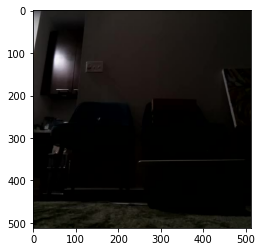

In [49]:
plt.imshow(x[0].numpy())

In [121]:
model_one.trainable_variables

[<tf.Variable 'model_one_1/conv2d_18/kernel:0' shape=(7, 7, 3, 32) dtype=float32, numpy=
 array([[[[-0.12198285,  0.04801698, -0.03996614, ..., -0.06027117,
            0.03051328, -0.03966011],
          [ 0.06450369, -0.07529315, -0.1640312 , ..., -0.10509982,
            0.07373799, -0.02622929],
          [ 0.00688406, -0.02311485, -0.07696161, ...,  0.02839833,
           -0.00978405,  0.02652629]],
 
         [[-0.02050254,  0.02257125, -0.00378083, ..., -0.02120611,
            0.03011017, -0.07999895],
          [ 0.09265772,  0.01425854, -0.11829692, ..., -0.01841785,
            0.06189806, -0.09601248],
          [-0.00473054,  0.0008738 , -0.0374729 , ...,  0.02907391,
            0.02199523, -0.10468139]],
 
         [[-0.06993955, -0.00537567,  0.02695637, ...,  0.00924011,
           -0.06608245, -0.01636006],
          [ 0.08374785, -0.10672174, -0.14234054, ..., -0.05673965,
           -0.10647074, -0.07110932],
          [ 0.00931593, -0.11731718, -0.08283673, ..., -0

In [142]:
p = []
y_true = []
for x, y in train_ds:
    preds = model_one(x)
    for p_i in preds:
        p.append(np.argmax(p_i.numpy()))
    for y_i in y:
        y_true.append(y_i)

In [143]:
np.sum(np.array(p) == np.array(y_true)) / len(y_true)

0.42030395378155433

In [144]:
analysis = {x:{'data': {x:0 for x in range(5)}, 'total': 0} for x in range(5)}

In [145]:
analysis

{0: {'data': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}, 'total': 0},
 1: {'data': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}, 'total': 0},
 2: {'data': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}, 'total': 0},
 3: {'data': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}, 'total': 0},
 4: {'data': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}, 'total': 0}}

In [146]:
for i in range(len(p)):
    actual = y_true[i].numpy()
    pred = p[i]
    analysis[actual]['data'][pred] += 1
    analysis[actual]['total'] += 1

In [147]:
for actual in analysis.keys():
    total = analysis[actual]['total']
    for pred in analysis[actual]['data'].keys():
        analysis[actual]['data'][pred] /= total

In [141]:
#test_ds
analysis

{0: {'data': {0: 0.9998146775389177,
   1: 0.0,
   2: 0.0,
   3: 0.0,
   4: 0.00018532246108228317},
  'total': 5396},
 1: {'data': {0: 0.0, 1: 1.0, 2: 0.0, 3: 0.0, 4: 0.0}, 'total': 5398},
 2: {'data': {0: 0.0,
   1: 0.0,
   2: 0.9996294924045943,
   3: 0.0003705075954057058,
   4: 0.0},
  'total': 5398},
 3: {'data': {0: 0.0,
   1: 0.0,
   2: 0.0,
   3: 0.9995334732913459,
   4: 0.00046652670865407047},
  'total': 4287},
 4: {'data': {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 1.0}, 'total': 17274}}

In [148]:
#train_ds
analysis

{0: {'data': {0: 0.021381227282446014,
   1: 0.566014539234552,
   2: 0.0025122942056874063,
   3: 0.040303613427410734,
   4: 0.3697883258499038},
  'total': 18708},
 1: {'data': {0: 0.21199219442966116,
   1: 0.44420791200993437,
   2: 0.0015374608243155343,
   3: 0.032464076636508785,
   4: 0.3097983560995802},
  'total': 16911},
 2: {'data': {0: 0.00016036777676805474,
   1: 0.11883252258512857,
   2: 0.023894798738440155,
   3: 0.5032875394237452,
   4: 0.3538247714759181},
  'total': 18707},
 3: {'data': {0: 0.005826695889239323,
   1: 0.027957449083230876,
   2: 0.1730902870583204,
   3: 0.33901748008766774,
   4: 0.45410808788154167},
  'total': 18707},
 4: {'data': {0: 0.0,
   1: 0.002382155489785606,
   2: 0.0,
   3: 0.0,
   4: 0.9976178445102144},
  'total': 27706}}

In [84]:
class_folders

['right', 'left', 'backwards', 'forwards', 'none']

In [50]:
class_folders

['right', 'left', 'backwards', 'forwards', 'none']

In [183]:
model_one(np.array([np.random.random((512, 512, 3))]))

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[1.3235223e-10, 8.9006849e-15, 1.4051939e-11, 4.4017568e-02,
        9.5598239e-01]], dtype=float32)>

In [187]:
os.listdir()

['model_training.ipynb',
 'results',
 'Archive.zip',
 '.ipynb_checkpoints',
 'data']

In [188]:
from PIL import Image

In [553]:
img = Image.open('./test.jpeg')
img = np.array(img) / 255.0

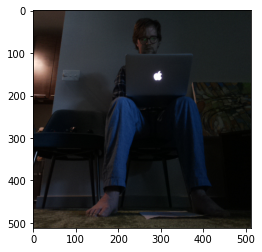

In [554]:
plt.imshow(img)

In [555]:
np.argmax(model_one([img]))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



2

In [262]:
model_one([img])

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[9.8254450e-02, 1.3661046e-06, 3.8763188e-05, 9.0170532e-01,
        2.7158200e-16]], dtype=float32)>

In [200]:
for x, y in train_ds:
    test_x = x
    test_y = y
    break

tf.Tensor(0, shape=(), dtype=int64)


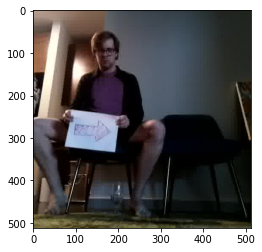

In [252]:
plt.imshow(x[0].numpy())
print(y[0])

In [255]:
np.argmax(model_one([x[0].numpy()]))

0

tf.Tensor(2, shape=(), dtype=int64)


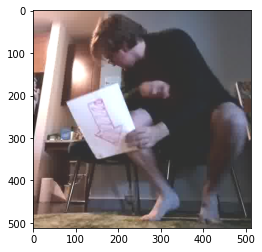

In [204]:
plt.imshow(x[1].numpy())
print(y[1])

tf.Tensor(1, shape=(), dtype=int64)


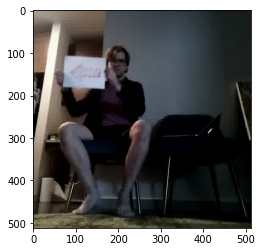

In [205]:
plt.imshow(x[2].numpy())
print(y[2])

tf.Tensor(0, shape=(), dtype=int64)


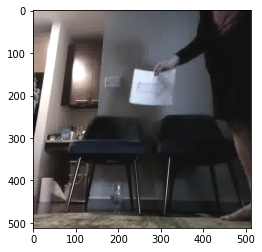

In [212]:
plt.imshow(x[33].numpy())
print(y[33])

In [206]:
class_folders

['right', 'left', 'backwards', 'forwards', 'none']

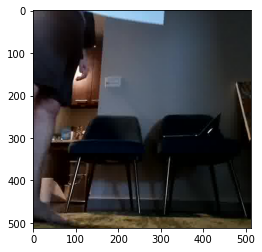

In [489]:
im = Image.open('./data/test/left/3893.jpg')
plt.imshow(im)

In [491]:
im = np.array(im) / 255.

In [493]:
model_one([im])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: shape=(1, 5), dtype=float32, numpy=array([[0., 0., 0., 0., 1.]], dtype=float32)>

In [ ]:
for x, y in test_ds

# Converting model to TFLite

In [60]:
converter = tf.lite.TFLiteConverter.from_keras_model(model=model_one)
# converter.optiamizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
open('./results/arix_model_final.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp5dot2_oz/assets


INFO:tensorflow:Assets written to: /tmp/tmp5dot2_oz/assets


13464108

In [54]:
model = tf.lite.Interpreter(model_path='./results/arix_model_final.tflite')
model.resize_tensor_input(0, (1, 512, 512, 3))
model.allocate_tensors()

In [57]:
y_hat = []
y_true = []

for x, y in t_ds:
    
    for ind in x:
        input_details = model.get_input_details()
        output_details = model.get_output_details()

        model.set_tensor(input_details[0]['index'], np.expand_dims(ind.numpy(), axis=0))
        model.invoke()
        preds = model.get_tensor(output_details[0]['index'])
#     for p in preds:
        y_hat.append(np.argmax(preds))
        
    for a in y:
        y_true.append(4)



In [58]:
np.sum(np.array(y_hat) == np.array(y_true)) / len(y_hat)

0.7108843537414966

In [59]:
y_hat

[4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 4,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 4,
 4,
 4,
 4,
 4,
 0,
 4,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 0,
 0,
 4,
 4,
 4,
 4,
 4,
 0,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 0,
 0,
 0,
 4,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 4,
 0,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 0,
 4,
 4,
 0,
 0,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 0,
 4,
 4,
 4,
 4,
 0,
 0,
 0,
 4,
 4,
 0,
 4,
 0,
 4,
 4,
 0,
 0,
 4,
 4,
 0,
 0,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 0,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 0,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 4,
 0,
 4,
 4,
 4,


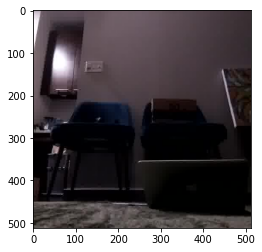

In [345]:
plt.imshow(x[1].numpy())

In [346]:
model_one.trainable_weights

[<tf.Variable 'model_one_21/conv2d_48/kernel:0' shape=(3, 3, 3, 16) dtype=float32, numpy=
 array([[[[-0.02381647, -0.15581611,  0.0142769 ,  0.01878494,
            0.13904628,  0.11875798,  0.20963854,  0.15217353,
           -0.00454835, -0.15008363, -0.10405778, -0.15602466,
            0.09517039,  0.05682226, -0.07404625,  0.17392056],
          [ 0.1651215 , -0.12473516, -0.23116869, -0.07609728,
           -0.0113906 , -0.20752048,  0.12353534,  0.18480614,
           -0.05729477, -0.11428998,  0.0746311 , -0.08840045,
           -0.18054706, -0.0737188 , -0.21871036, -0.03696305],
          [ 0.1434894 , -0.07711103, -0.21942745,  0.11970512,
            0.10468709, -0.08937377,  0.24742796, -0.08017492,
           -0.12452831,  0.11091974, -0.09003659, -0.06648792,
            0.09987845, -0.11556363, -0.13133511, -0.12917636]],
 
         [[ 0.20624526, -0.09168259,  0.10640513,  0.00613284,
            0.0250776 ,  0.04547858, -0.01447736,  0.14394023,
            0.1520221 

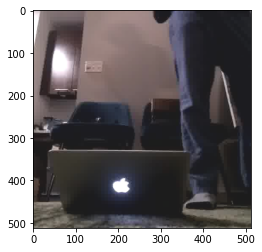

In [322]:
plt.imshow(x[-1].numpy())

In [333]:
np.sum(np.equal(np.array(y_hat), np.array(y_true))) / len(y_hat)

1.0

In [324]:
y_true[-1]

4

In [154]:
os.listdir('./results/')

['model_one']

In [32]:
class ModelTwo(tf.keras.Model):
    
    def __init__(self):
        super().__init__()
        self.c1 = Conv2D(16, kernel_size=(3, 3), strides=2, activation='relu')
        self.m1 = MaxPooling2D((2, 2), strides=2)
        self.c2 = Conv2D(32, kernel_size=(3, 3), strides=2, activation='relu')
        self.m2 = MaxPooling2D((2, 2), strides=2)
        self.c3 = Conv2D(64, kernel_size=(3, 3), strides=2, activation='relu')
        self.m3 = MaxPooling2D((2, 2), strides=2)
        self.f = Flatten()
        self.d1 = Dense(256)
        self.out = Dense(5, activation='softmax')
    
    def call(self, x):
        x = self.c1(x)
        x = self.m1(x)
        x = self.c2(x)
        x = self.m2(x)
        x = self.c3(x)
        x = self.m3(x)
        x = self.f(x)
        x = self.d1(x)
        return self.out(x)

In [33]:
model_two = ModelTwo()

loss = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
metric = tf.keras.metrics.SparseCategoricalAccuracy()

In [34]:
model_two(x)

<tf.Tensor: shape=(128, 5), dtype=float32, numpy=
array([[0.19981018, 0.20621347, 0.20431516, 0.1985388 , 0.19112241],
       [0.19864959, 0.20191945, 0.20719355, 0.19760673, 0.19463071],
       [0.19127685, 0.2087379 , 0.19727884, 0.2016005 , 0.20110588],
       [0.19819911, 0.20626152, 0.19972147, 0.2017806 , 0.1940373 ],
       [0.19330405, 0.20759153, 0.19963302, 0.20326294, 0.19620852],
       [0.20804961, 0.20210524, 0.19420308, 0.19744013, 0.19820188],
       [0.20574112, 0.20245136, 0.19419327, 0.19800319, 0.19961102],
       [0.20108473, 0.20822549, 0.19569671, 0.20770158, 0.18729147],
       [0.19827576, 0.21256274, 0.19803694, 0.2043813 , 0.18674326],
       [0.20082095, 0.20172447, 0.20728616, 0.19405212, 0.19611628],
       [0.20235324, 0.19978848, 0.20836522, 0.19939744, 0.19009559],
       [0.20193607, 0.20321655, 0.2021576 , 0.19621034, 0.19647947],
       [0.19955185, 0.20581491, 0.20689389, 0.19413629, 0.19360305],
       [0.20039868, 0.21266946, 0.19869058, 0.2035124

In [35]:
model_two.summary()

Model: "model_two_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            multiple                  448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_9 (Conv2D)            multiple                  4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_10 (Conv2D)           multiple                  18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten_3 (Flatten)          multiple                  

In [36]:
@tf.function
def train(x, y):
    with tf.GradientTape() as tape:
        preds = model_two(x)
        loss_ = loss(y, preds)
    grads = tape.gradient(loss_, model_two.trainable_variables)
    optimizer.apply_gradients(zip(grads, model_two.trainable_variables))
    return loss_, preds

In [37]:
EPOCHS = 10

loss_hist = []
acc_hist = []

for _ in range(EPOCHS):
    print(f'Epoch: {_}')
    for x, y in test_ds:
        l, p = train(x, y)
        loss_hist.append(l)
        acc_hist.append(metric(y, p))
        

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9


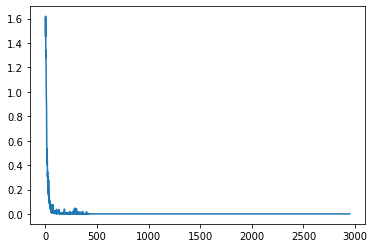

In [38]:
plt.plot(loss_hist)

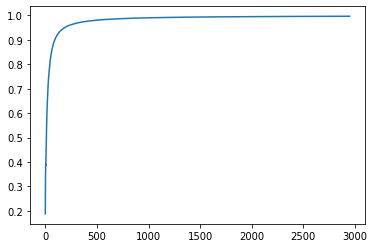

In [39]:
plt.plot(acc_hist)

In [144]:
y_hat = []
y_true = []

for x, y in test_ds:
    preds = model_two(x)
    for p in preds:
        y_hat.append(np.argmax(p.numpy()))
        
    for a in y:
        y_true.append(a.numpy())
        
np.sum(np.array(y_hat) == np.array(y_true)) / len(y_hat)

1.0

In [145]:
model_two.summary()

Model: "model_two_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           multiple                  448       
_________________________________________________________________
max_pooling2d_20 (MaxPooling multiple                  0         
_________________________________________________________________
conv2d_43 (Conv2D)           multiple                  5220      
_________________________________________________________________
flatten_18 (Flatten)         multiple                  0         
_________________________________________________________________
dense_19 (Dense)             multiple                  714425    
Total params: 720,093
Trainable params: 720,093
Non-trainable params: 0
_________________________________________________________________


In [146]:
model_one.summary()

Model: "model_one_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           multiple                  448       
_________________________________________________________________
batch_normalization_36 (Batc multiple                  64        
_________________________________________________________________
conv2d_41 (Conv2D)           multiple                  4640      
_________________________________________________________________
batch_normalization_37 (Batc multiple                  128       
_________________________________________________________________
max_pooling2d_19 (MaxPooling multiple                  0         
_________________________________________________________________
flatten_17 (Flatten)         multiple                  0         
_________________________________________________________________
dense_18 (Dense)             multiple                 

In [61]:
from functools import reduce

def factors(n):    
    return set(reduce(list.__add__, 
                ([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0)))

In [62]:
f_1920 = factors(1920)
f_1080 = factors(1080)

In [63]:
f_1920

{1,
 2,
 3,
 4,
 5,
 6,
 8,
 10,
 12,
 15,
 16,
 20,
 24,
 30,
 32,
 40,
 48,
 60,
 64,
 80,
 96,
 120,
 128,
 160,
 192,
 240,
 320,
 384,
 480,
 640,
 960,
 1920}

In [64]:
f_1080

{1,
 2,
 3,
 4,
 5,
 6,
 8,
 9,
 10,
 12,
 15,
 18,
 20,
 24,
 27,
 30,
 36,
 40,
 45,
 54,
 60,
 72,
 90,
 108,
 120,
 135,
 180,
 216,
 270,
 360,
 540,
 1080}

In [65]:
[x for x in f_1920 if x in f_1080]

[1, 2, 3, 4, 5, 6, 8, 10, 12, 15, 20, 24, 30, 40, 60, 120]

In [66]:
1920/120

16.0

In [67]:
1080/120

9.0

In [78]:
x_coords = []
y_coords = []

i = 120

while i <= 1080:
    x_coords.append(i)
    i += 120
    
i = 120

while i <= 1920:
    y_coords.append(i)
    i += 120

In [79]:
x_coords

[120, 240, 360, 480, 600, 720, 840, 960, 1080]

In [80]:
y_coords

[120,
 240,
 360,
 480,
 600,
 720,
 840,
 960,
 1080,
 1200,
 1320,
 1440,
 1560,
 1680,
 1800,
 1920]

In [81]:
img_slices = []

for i in x_coords:
    for j in y_coords:
        img_slices.append([i, j])

In [82]:
img_slices

[[120, 120],
 [120, 240],
 [120, 360],
 [120, 480],
 [120, 600],
 [120, 720],
 [120, 840],
 [120, 960],
 [120, 1080],
 [120, 1200],
 [120, 1320],
 [120, 1440],
 [120, 1560],
 [120, 1680],
 [120, 1800],
 [120, 1920],
 [240, 120],
 [240, 240],
 [240, 360],
 [240, 480],
 [240, 600],
 [240, 720],
 [240, 840],
 [240, 960],
 [240, 1080],
 [240, 1200],
 [240, 1320],
 [240, 1440],
 [240, 1560],
 [240, 1680],
 [240, 1800],
 [240, 1920],
 [360, 120],
 [360, 240],
 [360, 360],
 [360, 480],
 [360, 600],
 [360, 720],
 [360, 840],
 [360, 960],
 [360, 1080],
 [360, 1200],
 [360, 1320],
 [360, 1440],
 [360, 1560],
 [360, 1680],
 [360, 1800],
 [360, 1920],
 [480, 120],
 [480, 240],
 [480, 360],
 [480, 480],
 [480, 600],
 [480, 720],
 [480, 840],
 [480, 960],
 [480, 1080],
 [480, 1200],
 [480, 1320],
 [480, 1440],
 [480, 1560],
 [480, 1680],
 [480, 1800],
 [480, 1920],
 [600, 120],
 [600, 240],
 [600, 360],
 [600, 480],
 [600, 600],
 [600, 720],
 [600, 840],
 [600, 960],
 [600, 1080],
 [600, 1200],
 [60